In [1]:
import os
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Bidirectional, LSTM, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Reshape
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import load_img, img_to_array
print("Done")

Done


In [2]:
# Dataset path and parameters
dataset_path = '/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'
img_size = 150
batch_size = 64
classes = ['Normal', 'Cyst', 'Tumor', 'Stone']

# Load and preprocess the dataset
def load_data(dataset_path, classes):
    data = []
    labels = []
    for i, class_name in enumerate(classes):
        class_path = os.path.join(dataset_path, class_name)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            try:
                img = cv2.imread(img_path)
                img = cv2.resize(img, (img_size, img_size))
                data.append(img)
                labels.append(i)
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
    return np.array(data), np.array(labels)

data, labels = load_data(dataset_path, classes)

In [3]:
# Normalize and one-hot encode
data = data / 255.0
labels = to_categorical(labels, num_classes=len(classes))
#labels

In [4]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [5]:
# CNN with BiLSTM model
input_layer = Input(shape=(img_size, img_size, 3))

# CNN Layers
x = Conv2D(32, (3, 3), activation='relu')(input_layer)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = GlobalAveragePooling2D()(x)  # Convert feature maps to 1D vector

# Reshape for BiLSTM
x = Reshape((1, -1))(x)  # Reshape to (batch_size, timesteps=1, features)

# BiLSTM Layer
x = Bidirectional(LSTM(128, return_sequences=False))(x)

# Fully Connected Layers
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(len(classes), activation='softmax')(x)

# Create the model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(), loss='categorical_crossentropy', metrics=['accuracy'])

In [6]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=batch_size,
    epochs=80,
    verbose=1
)

Epoch 1/80
140/140 ━━━━━━━━━━━━━━━━━━━━ 14s 68ms/step - accuracy: 0.4293 - loss: 1.2673 - val_accuracy: 0.5837 - val_loss: 1.0752
Epoch 2/80
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.5769 - loss: 1.0875 - val_accuracy: 0.6207 - val_loss: 0.9877
Epoch 3/80
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.6163 - loss: 1.0060 - val_accuracy: 0.6399 - val_loss: 0.9357
Epoch 4/80
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.6320 - loss: 0.9765 - val_accuracy: 0.6613 - val_loss: 0.9117
Epoch 5/80
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.6464 - loss: 0.9404 - val_accuracy: 0.6399 - val_loss: 0.9030
Epoch 6/80
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.6666 - loss: 0.9024 - val_accuracy: 0.6662 - val_loss: 0.8884
Epoch 7/80
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.6801 - loss: 0.8560 - val_accuracy: 0.6609 - val_loss: 0.9082
Epoch 8/80
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.6871 - loss: 0.8379 - val_acc

In [7]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Save the model
model.save('cnn_bilstm_kidney_classification.h5')

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8885 - loss: 0.4043
Test Accuracy: 88.92%


Test Accuracy: 88.92%

Classification Report:
              precision    recall  f1-score   support

      Normal       0.84      1.00      0.91       526
        Cyst       0.92      1.00      0.96       373
       Tumor       1.00      0.58      0.73       236
       Stone       0.92      0.65      0.77       110

    accuracy                           0.89      1245
   macro avg       0.92      0.81      0.84      1245
weighted avg       0.90      0.89      0.88      1245

Precision: 0.9021%
Recall: 0.8892%
F1 Score: 0.8796%

Confusion Matrix:
[[526   0   0   0]
 [  1 372   0   0]
 [ 84   9 137   6]
 [ 16  22   0  72]]


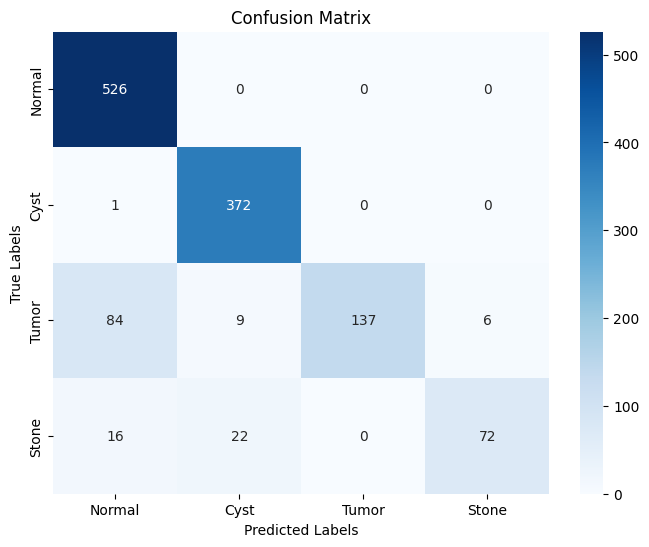

In [8]:
# Evaluate the model on the test data
from sklearn.metrics import precision_score, recall_score, f1_score
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Predict on the test set
y_pred = model.predict(X_test, verbose=0)

# Convert predictions and true labels to categorical format
y_pred_classes = np.argmax(y_pred, axis=1)  # Predicted classes
y_true_classes = np.argmax(y_test, axis=1)  # True classes

# Calculate precision, recall, and F1-score
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=classes))


# Calculate precision, recall, F1 score, and confusion matrix
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')


# Print the results
print(f"Precision: {precision:.4f}%")
print(f"Recall: {recall:.4f}%")
print(f"F1 Score: {f1:.4f}%")


conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


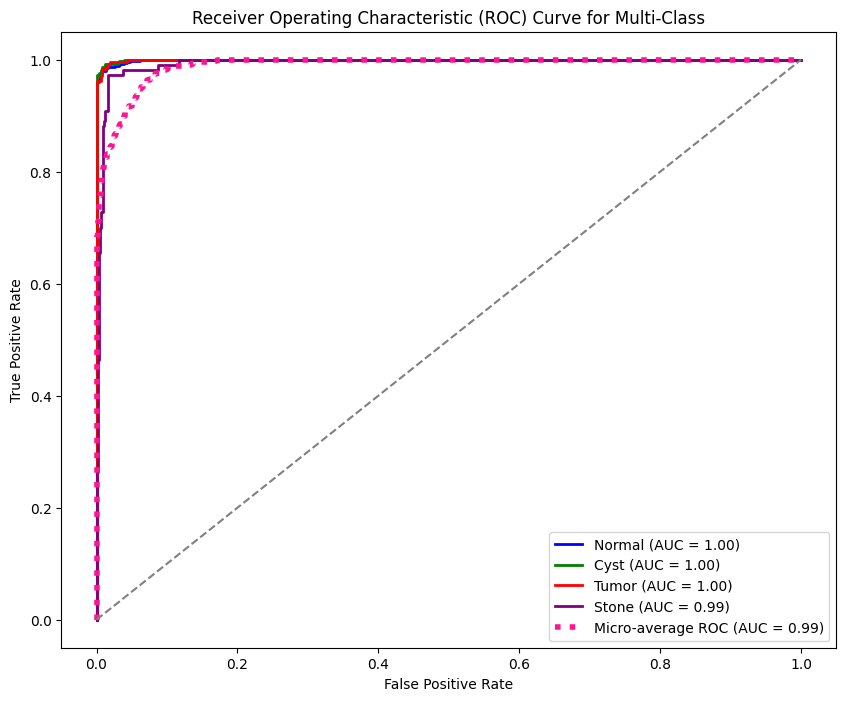

In [9]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
# Define class names
classes = ['Normal', 'Cyst', 'Tumor', 'Stone']


# Binarize the labels for multi-class (One-vs-Rest)
n_classes = y_test.shape[1]  # Assuming y_test is one-hot encoded
y_test_binarized = label_binarize(np.argmax(y_test, axis=1), classes=range(n_classes))
y_pred_probs = model.predict(X_test) 


# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_pred_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'red', 'purple']  # Add more colors if needed
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{classes[i]} (AUC = {roc_auc[i]:.2f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=4,
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.2f})')

# Plot the diagonal line
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Add plot labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multi-Class')
plt.legend(loc="lower right")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


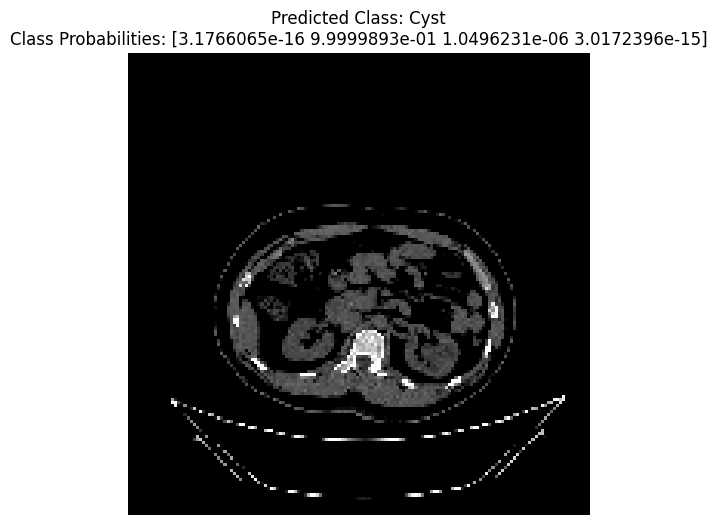

Predicted class: Cyst
Class probabilities: [3.1766065e-16 9.9999893e-01 1.0496231e-06 3.0172396e-15]


In [10]:
# Load and preprocess the image
image_path = '/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst/Cyst- (1009).jpg'

# Load the image with target size same as the input size of the model
img = load_img(image_path, target_size=(img_size, img_size))
img_array = img_to_array(img)  # Convert to numpy array
img_array = img_array / 255.0  # Normalize the image (same as during training)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Predict the class of the image
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions[0])  # Get the index of the highest probability

# Map the predicted index to the class name
predicted_class_name = classes[predicted_class]

# Plot the image
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.axis('off')  # Hide the axis
plt.title(f"Predicted Class: {predicted_class_name}\nClass Probabilities: {predictions[0]}")
plt.show()

# Print the result
print(f"Predicted class: {predicted_class_name}")
print(f"Class probabilities: {predictions[0]}")